# NOAA extreme weather events
The [National Oceanic and Atmospheric Administration](https://en.wikipedia.org/wiki/National_Oceanic_and_Atmospheric_Administration) has a database of extreme weather events that contains lots of detail for every year. [Link](https://www.climate.gov/maps-data/dataset/severe-storms-and-extreme-events-data-table).  I'll extract the data for 2018.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Unlimited columns

## Get official list of counties

In [46]:
import geopandas
# Import a shape file with all the counties in the US.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)

# Set the FIPS code as the index, and sort by it
counties = counties.set_index('FIPS').sort_index(axis=0)
    
# Make a list of the valid FIPS codes
official_counties = counties.index.tolist()

## Exploring one year of NOAA data
NOAA data comes year-by-year.  Here is an exploration of that one year, which will allow me to make a function that does this for any year.

In [4]:
# The full table contains more than I want to use.
df1 = pd.read_csv('../data_input/4_NOAA Storms/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')
print(df1.shape)
print(df1.columns)
df1.head(2)

(62169, 51)
Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201806,6,1810,201806,6,1810,125578,753161,NEBRASKA,31,2018,June,Hail,C,69,GARDEN,LBF,06-JUN-18 18:10:00,MST-7,06-JUN-18 18:10:00,0,0,0,0,0.00K,0.00K,Public,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,N,OSHKOSH,36.0,N,OSHKOSH,41.93,-102.21,41.93,-102.21,Severe storms developed in the Nebraska Panhan...,Hail predominately penny size with some quarte...,CSV
1,201806,6,1741,201806,6,1741,125578,753160,NEBRASKA,31,2018,June,Hail,C,161,SHERIDAN,LBF,06-JUN-18 17:41:00,MST-7,06-JUN-18 17:41:00,0,0,0,0,0.00K,0.00K,Trained Spotter,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NW,BINGHAM,1.0,NW,BINGHAM,42.03,-102.10,42.03,-102.10,Severe storms developed in the Nebraska Panhan...,Hail mainly quarter size with some half dollar...,CSV


In [15]:
# Extract only a few useful columns
df2 = df1[['STATE','STATE_FIPS','CZ_FIPS','EVENT_TYPE']].copy()

# Create new column for complete county FIPS code
state_FIPS = [str(x) for x in df2['STATE_FIPS']]
county_FIPS = [str(x) for x in df2['CZ_FIPS']]

# Make sure the string for county FIPS is 3 digits long.
county_FIPS_2 = []
for fip in county_FIPS:
    if len(fip) == 3:
        fip2 = fip
    elif len(fip) == 2:
        fip2 = '0' + fip
    elif len(fip) == 1:
        fip2 = '00' + fip
    county_FIPS_2.append(fip2)
    
# Create a full FIPS for each county
complete_FIPS = [int(x+y) for x, y in zip(state_FIPS, county_FIPS_2)]
df2['FIPS'] = complete_FIPS


# Drop entries for areas not in the list of counties that we're working
# with.  This includes counties in non-state territories (eg, Puerto Rico),
# areas over lakes and oceans, and several forecast zones that don't 
# correspond to particular counties.
df3 = df2[df2.FIPS.isin(official_counties)].copy()

# Drop obsolete columns
df3 = df3.drop(columns=['STATE_FIPS','CZ_FIPS'])

In [16]:
print(df3.shape)
df3.head()

(45865, 3)


,STATE,EVENT_TYPE,FIPS
0,NEBRASKA,Hail,31069
1,NEBRASKA,Hail,31161
2,VERMONT,Thunderstorm Wind,50011
3,VERMONT,Thunderstorm Wind,50015
4,NEBRASKA,Tornado,31135


In [17]:
# These are all event types from the metadata, edited to remove marine events
event_types = ['Astronomical Low Tide','Avalanche','Blizzard','Coastal Flood',
               'Cold/Wind Chill','Debris Flow','Dense Fog','Dense Smoke',
               'Drought','Dust Devil','Dust Storm','Excessive Heat',
               'Extreme Cold/Wind Chill','Flash Flood','Flood','Frost/Freeze',
               'Funnel Cloud','Freezing Fog','Hail','Heat','Heavy Rain',
               'Heavy Snow','High Surf','High Wind','Hurricane (Typhoon)',
               'Ice Storm','Lake-Effect Snow','Lakeshore Flood','Lightning',
               'Rip Current','Seiche','Sleet','Storm Surge/Tide','Strong Wind',
               'Thunderstorm Wind','Tornado','Tropical Depression',
               'Tropical Storm','Tsunami','Volcanic Ash','Wildfire',
               'Winter Storm','Winter Weather',]

In [18]:
df4 = df3.copy()

# Create a new column for every event type. Each row has a 1 in the column of
# its event type and a 0 for all others.
for typ in event_types:
    df4[typ] = (typ == df4['EVENT_TYPE']).astype(int)

In [19]:
df4.head()

,STATE,EVENT_TYPE,FIPS,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,Dust Storm,Excessive Heat,Extreme Cold/Wind Chill,Flash Flood,Flood,Frost/Freeze,Funnel Cloud,Freezing Fog,Hail,Heat,Heavy Rain,Heavy Snow,High Surf,High Wind,Hurricane (Typhoon),Ice Storm,Lake-Effect Snow,Lakeshore Flood,Lightning,Rip Current,Seiche,Sleet,Storm Surge/Tide,Strong Wind,Thunderstorm Wind,Tornado,Tropical Depression,Tropical Storm,Tsunami,Volcanic Ash,Wildfire,Winter Storm,Winter Weather
0,NEBRASKA,Hail,31069,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NEBRASKA,Hail,31161,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,VERMONT,Thunderstorm Wind,50011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,VERMONT,Thunderstorm Wind,50015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,NEBRASKA,Tornado,31135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [20]:
# Group by the FIPS code, summing up all the events for that county.
# Now the dataset has FIPS code as the index and contains one column for each
# event type.  Each cell is the number of events of that type for that county.
df5 = df4.groupby('FIPS').sum()

In [21]:
print(df5.shape)
df5.head()

(3019, 43)


,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,Dust Storm,Excessive Heat,Extreme Cold/Wind Chill,Flash Flood,Flood,Frost/Freeze,Funnel Cloud,Freezing Fog,Hail,Heat,Heavy Rain,Heavy Snow,High Surf,High Wind,Hurricane (Typhoon),Ice Storm,Lake-Effect Snow,Lakeshore Flood,Lightning,Rip Current,Seiche,Sleet,Storm Surge/Tide,Strong Wind,Thunderstorm Wind,Tornado,Tropical Depression,Tropical Storm,Tsunami,Volcanic Ash,Wildfire,Winter Storm,Winter Weather
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,6,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,1,0,0,0,0,0,1
1003,0,0,0,0,3,0,0,0,0,0,0,0,0,4,1,7,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,0,0,0,1
1005,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,6,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1007,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,7,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1
1009,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,8,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2,0,0,0,0,0,0,3


In [29]:
# I reindex the dataframe so that it contains a row for every county in
# the official county list. Counties without events are filled with 0.
df6 = df5.reindex(official_counties, fill_value=0)

In [30]:
print(df6.shape)
df6.head()

(3141, 43)


,Astronomical Low Tide,Avalanche,Blizzard,Coastal Flood,Cold/Wind Chill,Debris Flow,Dense Fog,Dense Smoke,Drought,Dust Devil,Dust Storm,Excessive Heat,Extreme Cold/Wind Chill,Flash Flood,Flood,Frost/Freeze,Funnel Cloud,Freezing Fog,Hail,Heat,Heavy Rain,Heavy Snow,High Surf,High Wind,Hurricane (Typhoon),Ice Storm,Lake-Effect Snow,Lakeshore Flood,Lightning,Rip Current,Seiche,Sleet,Storm Surge/Tide,Strong Wind,Thunderstorm Wind,Tornado,Tropical Depression,Tropical Storm,Tsunami,Volcanic Ash,Wildfire,Winter Storm,Winter Weather
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,6,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,1,0,0,0,0,0,1
1003,0,0,0,0,3,0,0,0,0,0,0,0,0,4,1,7,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,0,0,0,1
1005,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,6,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1007,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,7,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1
1009,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,8,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2,0,0,0,0,0,0,3


In [36]:
# These are the county-level extreme weather events reported un 2018.
df6.sum().sort_values(ascending=False)

Thunderstorm Wind          14604
Hail                        7838
Flood                       4688
Flash Flood                 4345
Winter Weather              2040
Heavy Rain                  1911
Winter Storm                1555
Tornado                     1247
High Wind                   1118
Heavy Snow                  1041
Drought                      940
Heat                         616
Strong Wind                  452
Lightning                    393
Blizzard                     383
Funnel Cloud                 347
Frost/Freeze                 310
Extreme Cold/Wind Chill      298
Dense Fog                    287
Cold/Wind Chill              249
Excessive Heat               203
Wildfire                     178
Coastal Flood                159
Tropical Storm               145
Debris Flow                  136
High Surf                    126
Ice Storm                     74
Dust Storm                    33
Lake-Effect Snow              24
Astronomical Low Tide         19
Rip Curren

## Processing all NOAA files

In [ ]:
# These are all event types from the metadata, edited to remove marine events
event_types = ['Astronomical Low Tide','Avalanche','Blizzard','Coastal Flood',
               'Cold/Wind Chill','Debris Flow','Dense Fog','Dense Smoke',
               'Drought','Dust Devil','Dust Storm','Excessive Heat',
               'Extreme Cold/Wind Chill','Flash Flood','Flood','Frost/Freeze',
               'Funnel Cloud','Freezing Fog','Hail','Heat','Heavy Rain',
               'Heavy Snow','High Surf','High Wind','Hurricane (Typhoon)',
               'Ice Storm','Lake-Effect Snow','Lakeshore Flood','Lightning',
               'Rip Current','Seiche','Sleet','Storm Surge/Tide','Strong Wind',
               'Thunderstorm Wind','Tornado','Tropical Depression',
               'Tropical Storm','Tsunami','Volcanic Ash','Wildfire',
               'Winter Storm','Winter Weather',]

In [130]:
def process_noaa(filepath):
    """
    Process one year of NOAA Extreme weather events. Requires
    the list of official counties and the list of official weather
    event types.
    
    Inputs
    ------
    filepath (string) : file path for the CSV data file.
    
    
    Outputs
    -------
    df6 (pandas.DataFrame) : Dataframe with the list of official FIPS
                                    codes as index and one column for each 
                                    disaster type handled by NOAA.
    
    """
    
    df1 = pd.read_csv(filepath)
    
    # Extract only a few important columns
    df2 = df1[['STATE_FIPS','CZ_FIPS','EVENT_TYPE']].copy()
    
    # Remove any rows with nulls
    df2 = df2.dropna()

    # Create new column for complete county FIPS code.
    # Ensure that FIPS are ints, otherwise string manipulation fails
    state_FIPS = [str(x) for x in df2['STATE_FIPS'].astype(int)]
    county_FIPS = [str(x) for x in df2['CZ_FIPS'].astype(int)]


    # Make sure the string for county FIPS is 3 digits long,
    # with trailing zeroes on the left.
    county_FIPS_2 = []
    for fip in county_FIPS:
        if len(fip) == 3:
            fip2 = fip
        elif len(fip) == 2:
            fip2 = '0' + fip
        elif len(fip) == 1:
            fip2 = '00' + fip
        county_FIPS_2.append(fip2)

    # Create a full FIPS for each county
    complete_FIPS = [int(x+y) for x, y in zip(state_FIPS, county_FIPS_2)]
    df2['FIPS'] = complete_FIPS

    # Drop entries for areas not in the list of counties that we're working
    # with.  This includes counties in non-state territories (eg, Puerto Rico),
    # areas over lakes and oceans, and several forecast zones that don't 
    # correspond to particular counties.
    df3 = df2[df2.FIPS.isin(official_counties)].copy()

    # Drop obsolete columns
    df4 = df3.drop(columns=['STATE_FIPS','CZ_FIPS'])

    # Create a new column for every event type. Each row has a 1 in the column of
    # its event type and a 0 for all others.
    for typ in event_types:
        df4[typ] = (typ == df4['EVENT_TYPE']).astype(int)
        
    # Group by the FIPS code, summing up all the events for that county.
    # Now the dataset has FIPS code as the index and contains one column for each
    # event type.  Each cell is the number of events of that type for that county.
    df5 = df4.groupby('FIPS').sum()
    
    # I reindex the dataframe so that it contains a row for every county in
    # the official county list. Counties without events are filled with 0.
    df6 = df5.reindex(official_counties, fill_value=0)
    
    return df6

In [153]:
import glob
import os

# Read the CSV files for each year going back to 1996 (the first year 
# when many of these event types started being recorded)
path = '../data_local/NOAA/'
filenames = sorted(glob.glob(os.path.join(path, '*.csv')))
years = []
layers = []

# Aggregate the dataframes in a list
for name in filenames:
    year = int(name[49:53])
    print(f'Processing {year}')
    years.append(year)
    layers.append(process_noaa(name))

# Concatenate all these dataframes into a single multi-layer dataframe
noaa = pd.concat(layers, keys=years)

Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


In [168]:
# Create an ordered list of the event types with highest counts
columns_by_most_events = noaa.groupby(level=0).sum().sum().sort_values(ascending=False).index

# Reorder the columns in that order
noaa = noaa[columns_by_most_events].copy()

# Create new df for comparison
noaa2 = noaa.copy()

# Rename some categories
new_names = {'Heat':'Heat old',
             'Flood':'Flood old', 
             'Winter Weather':'Winter Weather old',
             'Hurricane (Typhoon)':'Hurricane'}

noaa2 = noaa2.rename(columns=new_names)

# Create aggregate categories
noaa2['Winter Weather'] = noaa2['Winter Weather old'] +\
                            noaa2['Winter Storm'] +\
                            noaa2['Heavy Snow'] +\
                            noaa2['Frost/Freeze'] +\
                            noaa2['Freezing Fog'] +\
                            noaa2['Ice Storm'] +\
                            noaa2['Sleet'] +\
                            noaa2['Lake-Effect Snow'] +\
                            noaa2['Cold/Wind Chill'] +\
                            noaa2['Extreme Cold/Wind Chill'] +\
                            noaa2['Blizzard']

noaa2['Flood'] = noaa2['Flood old'] +\
                  noaa2['Flash Flood']+\
                  noaa2['Coastal Flood']+\
                  noaa2['Storm Surge/Tide']+\
                  noaa2['Lakeshore Flood']+\
                  noaa2['Debris Flow']               
                                
noaa2['Storm'] = noaa2['Thunderstorm Wind']+\
                  noaa2['High Wind']+\
                  noaa2['Funnel Cloud']+\
                  noaa2['Dust Storm']+\
                  noaa2['Strong Wind']+\
                  noaa2['Dust Devil']+\
                  noaa2['Tropical Depression']+\
                  noaa2['Lightning']+\
                  noaa2['Tropical Storm']+\
                  noaa2['High Surf']+\
                  noaa2['Heavy Rain']+\
                  noaa2['Hail']
    
noaa2['Fire'] = noaa2['Wildfire'] +\
                  noaa2['Dense Smoke']
    
noaa2['Heat'] = noaa2['Heat old'] +\
                  noaa2['Excessive Heat']

final_columns = ['Storm', 'Flood', 'Winter Weather', 'Tornado', 
                 'Drought', 'Heat', 'Fire', 'Hurricane']

# Some categories are excluded because they're not important enough
deliberately_ignored = ['Dense Fog', 'Rip Current','Astronomical Low Tide','Avalanche',
       'Seiche', 'Tsunami', 'Volcanic Ash']

noaa3 = noaa2[final_columns]

In [ ]:
# Aggregate data by county (years summed up)
noaa_county = noaa3.groupby(level=1).sum()

# Aggregate data by year (counties summed up)
noaa_year = noaa3.groupby(level=0).sum()

# Put the data by county into the geopandas file with county shapes
noaa_county_map = counties.merge(noaa_county, on='FIPS', how='left')

In [201]:
noaa_county_log = np.log(noaa_county+1)
noaa_county_map_log = counties.merge(noaa_county_log, on='FIPS', how='left')
noaa_county_map_log.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,geometry,Winter Weather,Storm,Flood,Fire,Heat,Drought,Tornado,Hurricane
FIPS,,,,,,,,,,,,,
1001,Autauga,Alabama,1,1,POLYGON ((-86.82066986329349 32.34730960076057...,4.369448,5.480639,3.367296,0.693147,3.583519,3.258097,3.295837,0.0
1003,Baldwin,Alabama,1,3,POLYGON ((-87.97308978075395 31.16482251520438...,4.234107,5.786897,4.564348,1.098612,3.091042,3.178054,3.713572,0.0
1005,Barbour,Alabama,1,5,POLYGON ((-85.74337279655801 31.62624052460075...,4.304065,4.820282,2.302585,0.000000,3.135494,3.367296,3.135494,0.0
1007,Bibb,Alabama,1,7,POLYGON ((-87.41985563876936 33.01177307648309...,4.343805,4.962845,2.772589,0.000000,2.995732,3.367296,2.833213,0.0
1009,Blount,Alabama,1,9,POLYGON ((-86.96799449037186 33.86045466926403...,4.521789,5.730100,3.637586,0.000000,2.484907,3.526361,3.433987,0.0


In [174]:
print(noaa_county_map.shape)
noaa_county_map.head()

(3141, 13)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,geometry,Winter Weather,Storm,Flood,Fire,Heat,Drought,Tornado,Hurricane
FIPS,,,,,,,,,,,,,
1001,Autauga,Alabama,1,1,POLYGON ((-86.82066986329349 32.34730960076057...,78,239,28,1,35,25,26,0
1003,Baldwin,Alabama,1,3,POLYGON ((-87.97308978075395 31.16482251520438...,68,325,95,2,21,23,40,0
1005,Barbour,Alabama,1,5,POLYGON ((-85.74337279655801 31.62624052460075...,73,123,9,0,22,28,22,0
1007,Bibb,Alabama,1,7,POLYGON ((-87.41985563876936 33.01177307648309...,76,142,15,0,19,28,16,0
1009,Blount,Alabama,1,9,POLYGON ((-86.96799449037186 33.86045466926403...,91,307,37,0,11,33,30,0


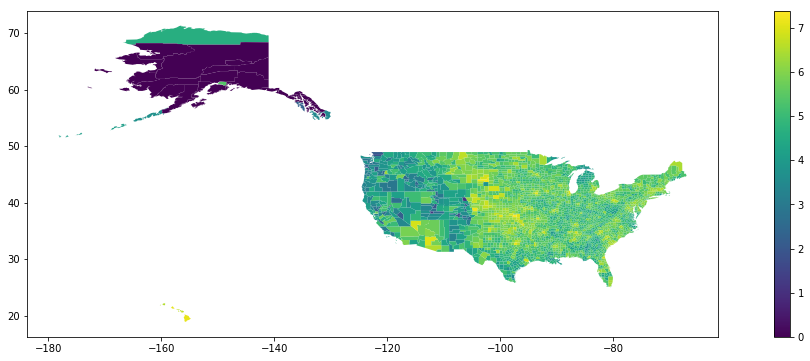

In [202]:
noaa_county_map_log.plot(column='Storm', figsize=(20,6), legend=True);

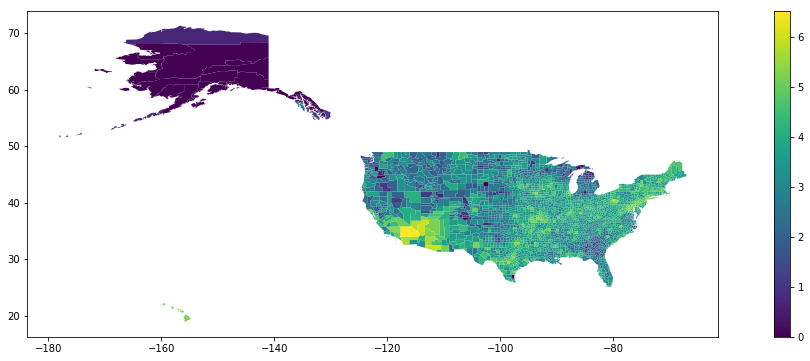

In [203]:
noaa_county_map_log.plot(column='Flood', figsize=(20,6), legend=True);

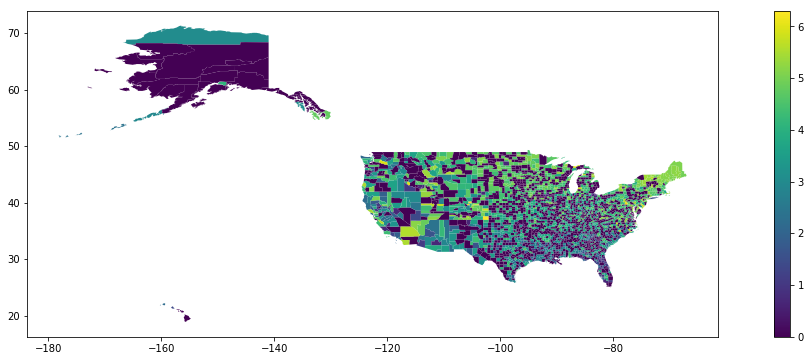

In [204]:
noaa_county_map_log.plot(column='Winter Weather', figsize=(20,6), legend=True);

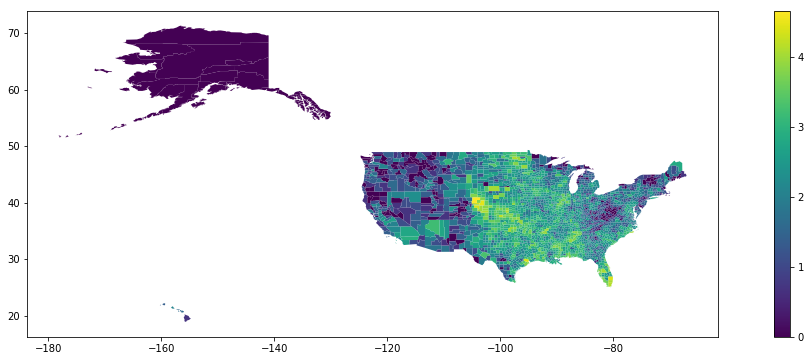

In [205]:
noaa_county_map_log.plot(column='Tornado', figsize=(20,6), legend=True);

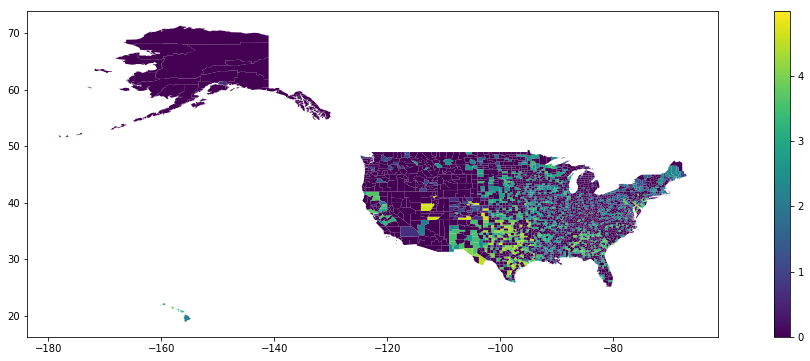

In [206]:
noaa_county_map_log.plot(column='Drought', figsize=(20,6), legend=True);

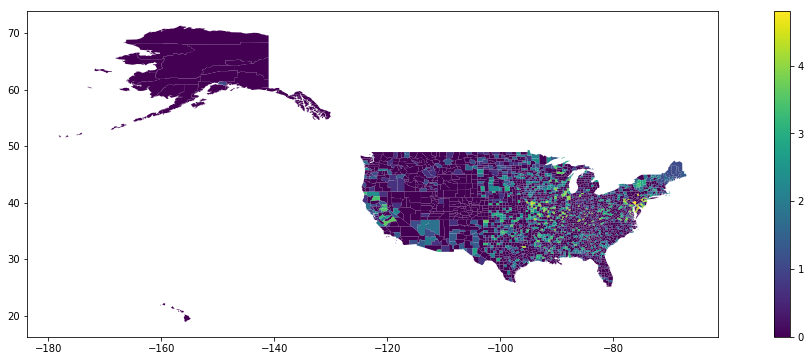

In [207]:
noaa_county_map_log.plot(column='Heat', figsize=(20,6), legend=True);

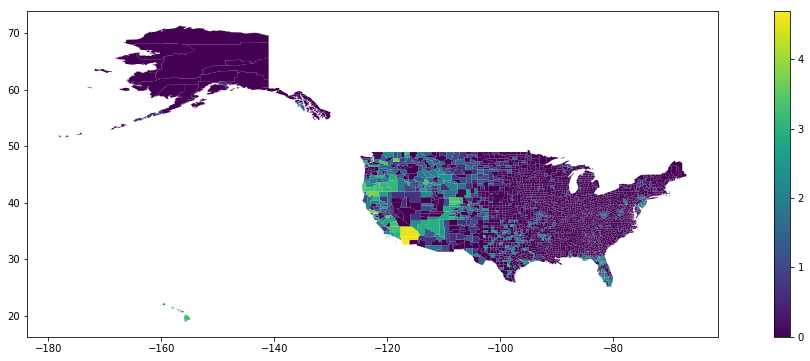

In [208]:
noaa_county_map_log.plot(column='Fire', figsize=(20,6), legend=True);

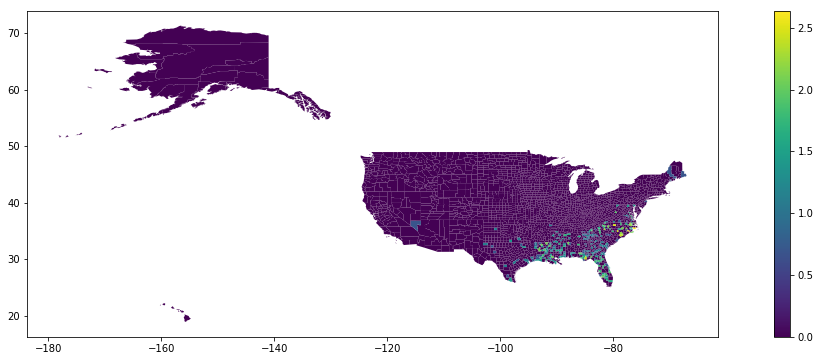

In [209]:
noaa_county_map_log.plot(column='Hurricane', figsize=(20,6), legend=True);

# What about those other zones?

In [216]:
url = 'https://www.weather.gov/source/gis/Shapefiles/County/bp02ap19.dbx'
cols = ['STATE','ZONE','CWA','NAME','STATE_ZONE','COUNTY','FIPS',
        'TIME_ZONE','FE_AREA','LAT','LON']
zones1 = pd.read_csv(url, delimiter='|', names=cols)

In [218]:
zones1.sort_values('FIPS')

,STATE,ZONE,CWA,NAME,STATE_ZONE,COUNTY,FIPS,TIME_ZONE,FE_AREA,LAT,LON
165,AL,41,BMX,Autauga,AL041,Autauga,1001,C,c,32.5349,-86.6428
195,AL,266,MOB,Baldwin Coastal,AL266,Baldwin,1003,C,sw,30.4940,-87.6699
191,AL,262,MOB,Baldwin Inland,AL262,Baldwin,1003,C,sw,30.4940,-87.6699
193,AL,264,MOB,Baldwin Central,AL264,Baldwin,1003,C,sw,30.9471,-87.7615
174,AL,50,BMX,Barbour,AL050,Barbour,1005,C,se,31.8696,-85.3932
158,AL,34,BMX,Bibb,AL034,Bibb,1007,C,c,32.9986,-87.1264
141,AL,17,BMX,Blount,AL017,Blount,1009,C,c,33.9809,-86.5674
170,AL,46,BMX,Bullock,AL046,Bullock,1011,C,se,32.1005,-85.7161
181,AL,57,MOB,Butler,AL057,Butler,1013,C,sc,31.7524,-86.6803
143,AL,19,BMX,Calhoun,AL019,Calhoun,1015,C,ec,33.7714,-85.8261
